In [ ]:
%env OUTPUT_PATH=/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples
%env DATA_SOURCE=/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset

2022-04-01 17:04:51,610:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/OK/
2022-04-01 17:04:51,613:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/NG/
2022-04-01 17:04:51,615:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/OK/
2022-04-01 17:04:51,616:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/NG/
2022-04-01 17:04:57,179:root:INFO - Training classifier and saving it locally


No. of training examples: 822
No. of training examples: 8
No. of validation examples: 8
No. of test examples: 806
Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 0.9992 - iou: 0.0015 - val_loss: 0.9955 - val_iou: 0.0044 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 17s 17s/step - loss: 0.9987 - iou: 0.0012 - val_loss: 0.9937 - val_iou: 0.0145 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 13s 13s/step - loss: 0.9973 - iou: 0.0064 - val_loss: 0.9977 - val_iou: 0.0029 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 14s 14s/step - loss: 0.9983 - iou: 0.0036 - val_loss: 0.9921 - val_iou: 0.0111 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 13s 13s/step - loss: 0.9959 - iou: 0.0059 - val_loss: 0.9882 - val_iou: 0.0150 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 14s 14s/step - loss: 0.9945 - iou: 0.0070 - val_loss: 0.9839 - val_iou: 0.0171 - lr: 0.0010
Epoch 7/10
1/1 [==================

2022-04-01 17:07:26,896:root:INFO - Writing tokenizer into /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples


INFO:tensorflow:Assets written to: /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/segmentation_model/assets


2022-04-01 17:07:33,213:tensorflow:INFO - Assets written to: /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/segmentation_model/assets


1/1 [==============================] - 4s 4s/step - loss: 0.9918 - iou: 0.0059


2022-04-01 17:07:37,009:root:INFO - -----START INFERENCE-----


2022-04-01 17:07:40,114:tensorflow:WARNING - 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x13fab3e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


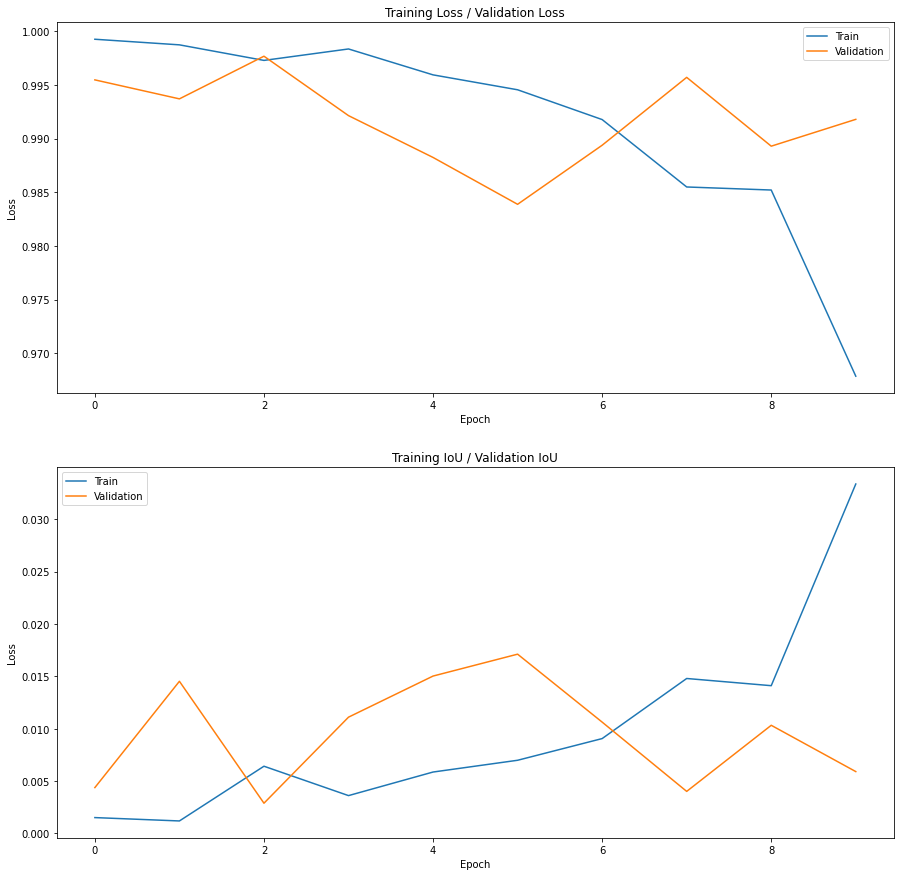

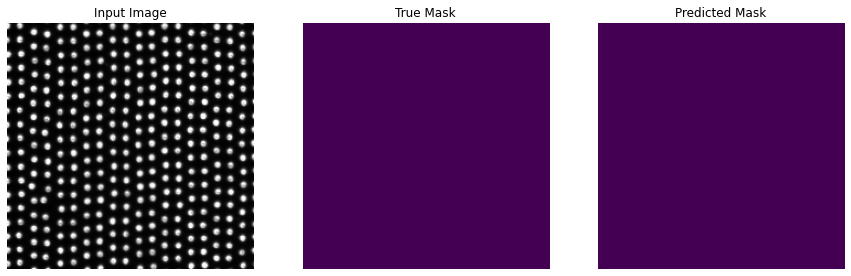

2022-04-01 17:07:40,786:root:INFO - -----END INFERENCE-----


In [44]:
# -*- coding: utf-8 -*-
"""
Training script to showcase the end-to-end training and evaluation script.
"""

import numpy as np
import pandas as pd
#import datetime
import logging
import cv2
import joblib
import os
import keras
import ast

#from sapai import tracking
from os.path import exists
from joblib import load, dump
from os import makedirs, environ
import tensorflow as tf
from tensorflow.keras import layers, Model, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow_datasets
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import schedules, Adamax
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Conv2D,\
    MaxPool2D, Conv2DTranspose, Input, Activation,\
    Concatenate, CenterCrop
import tensorflow.keras.metrics as tfm
from tensorflow.keras.callbacks import ReduceLROnPlateau


FORMAT = "%(asctime)s:%(name)s:%(levelname)s - %(message)s"
# Use filename="file.log" as a param to logging to log to a file
logging.basicConfig(format=FORMAT, level=logging.INFO)


class IoUCustom(tfm.IoU):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_new = y_true[:,:,:,0]
        y_true_new = y_true_new[..., tf.newaxis]
        y_pred_new = tf.argmax(y_pred, axis=-1)
        y_pred_new = y_pred_new[..., tf.newaxis]
        return super(tfm.IoU, self).update_state(y_true_new, y_pred_new, sample_weight)


class TrainSKInterface:
    def __init__(self) -> None:
        # Set the params for the training below
        self.image_pipeline = None
        self.dataset_all = None
        self.train, self.val, self.test = None, None, None
        self.dataset_name = "lgp_dataset"
        self.model_name = "segmentation_model"
        self.output_path = environ["OUTPUT_PATH"]
        self.file_name = environ["DATA_SOURCE"]
        self.loss = None
        self.val_loss = None
        self.accuracy = None
        self.val_accuracy = None
        self.IMG_WIDTH = 224
        self.IMG_HEIGHT = 224
        self.MSK_WIDTH = 184
        self.MSK_HEIGHT = 184
        self.target_classes = None
        self.training_metrics = None

    
    def create_dataset(self, img_folder, bnw, binary, width, height):
        img_data_array = []
        color_str = cv2.IMREAD_COLOR
        color_int = 3
        if(bnw):
            color_str = cv2.cv2.IMREAD_GRAYSCALE
            color_int = 1
        for file in sorted(os.listdir(img_folder)):
                image_path = os.path.join(img_folder, file)
                image = cv2.imread(image_path, color_str)
                image = cv2.resize(image, (height, width), interpolation = cv2.INTER_AREA)
                image = np.array(image)
                image = image.astype('float32')
                image /= 255
                image = np.reshape(image, (width, height, color_int))
                if(bnw):
                    image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)[1]
                if(binary):
                    image = image.tobytes()
                img_data_array.append(image)
        return img_data_array
    

    def read_dataset(self) -> None:
        """
        Reads the images file from path
        """
        
        path_img_ok = self.file_name + "/Images/OK/"
        path_img_ko = self.file_name + "/Images/NG/"
        path_msk_ok = self.file_name + "/Masks/OK/"
        path_msk_ko = self.file_name + "/Masks/NG/"
        
        logging.info(f"{path_img_ok}")
        logging.info(f"{path_img_ko}")
        logging.info(f"{path_msk_ok}")
        logging.info(f"{path_msk_ko}")
        
        img_dataset_ok_bin = self.create_dataset(path_img_ok, False, True, self.IMG_WIDTH, self.IMG_HEIGHT)
        img_dataset_ko_bin = self.create_dataset(path_img_ko, False, True, self.IMG_WIDTH, self.IMG_HEIGHT)
        msk_dataset_ok_bin = self.create_dataset(path_msk_ok, True, True, self.MSK_WIDTH, self.MSK_HEIGHT)
        msk_dataset_ko_bin = self.create_dataset(path_msk_ko, True, True, self.MSK_WIDTH, self.MSK_HEIGHT)

        df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
        df_img_dataset_ok['image'] = img_dataset_ok_bin
        df_img_dataset_ok['label'] = 0
        df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
        df_img_dataset_ko['image'] = img_dataset_ko_bin
        df_img_dataset_ko['label'] = 1
        
        df_msk_dataset_ok = pd.DataFrame(columns = ['mask'])
        df_msk_dataset_ok['mask'] = msk_dataset_ok_bin
        df_msk_dataset_ko = pd.DataFrame(columns = ['mask'])
        df_msk_dataset_ko['mask'] = msk_dataset_ko_bin

        df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
        df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)
        
        self.dataset_all = pd.merge(df_img_dataset_tot, df_msk_dataset_tot, left_index=True, right_index=True)
        self.dataset_all = self.dataset_all.sample(frac=1).reset_index(drop=True)
        print(f"No. of training examples: {self.dataset_all.shape[0]}")
        
        return None


    def split_dataset(self) -> None:
        """
        Split the dataset into train, validate and test

        Raises:
            Error: if dataset_train and dataset_test are not set
        """
        if self.dataset_all is None:
            raise Exception("Train or test data not set")

        #Change splitting proportions
        self.train, self.val = train_test_split(self.dataset_all, test_size=0.99, random_state=25)
        self.val, self.test = train_test_split(self.val, test_size=0.99, random_state=25)

        print(f"No. of training examples: {self.train.shape[0]}")
        print(f"No. of validation examples: {self.val.shape[0]}")
        print(f"No. of test examples: {self.test.shape[0]}")

        return None

    
    def convert_back(self, df, category, color_int, width, height):
        temp_arr = []
        for i in df[category].values:
            a = np.frombuffer(i, dtype=np.float32)
            a = a.reshape(width,height,color_int)
            temp_arr.append(a)
            #print(a.shape)
        return temp_arr

    
    def conv_block(self, x, filters, last_block):
        '''
            U-Net convolutional block.
            Used for downsampling in the contracting path.
        '''
        config = self.configuration()

        # First Conv segment
        x = Conv2D(filters, (3, 3),\
            kernel_initializer=config.get("initializer"))(x)
        x = Activation("relu")(x)

        # Second Conv segment
        x = Conv2D(filters, (3, 3),\
            kernel_initializer=config.get("initializer"))(x)
        x = Activation("relu")(x)

        # Keep Conv output for skip input
        skip_input = x

        # Apply pooling if not last block
        if not last_block:
            x = MaxPool2D((2, 2), strides=(2,2))(x)

        return x, skip_input
    
    
    def compute_number_of_filters(self, block_number):
        '''
        Compute the number of filters for a specific
        U-Net block given its position in the contracting path.
        '''
        return self.configuration().get("num_filters_start") * (2 ** block_number)
    
    
    def contracting_path(self, x):
        '''
            U-Net contracting path.
            Initializes multiple convolutional blocks for 
            downsampling.
        '''
        config = self.configuration()

        # Compute the number of feature map filters per block
        num_filters = [self.compute_number_of_filters(index)\
                for index in range(config.get("num_unet_blocks"))]

        # Create container for the skip input Tensors
        skip_inputs = []

        # Pass input x through all convolutional blocks and
        # add skip input Tensor to skip_inputs if not last block
        for index, block_num_filters in enumerate(num_filters):

            last_block = index == len(num_filters)-1
            x, skip_input = self.conv_block(x, block_num_filters,\
                last_block)

            if not last_block:
                skip_inputs.append(skip_input)

        return x, skip_inputs
    
    
    def upconv_block(self, x, filters, skip_input, last_block = False):
        '''
            U-Net upsampling block.
            Used for upsampling in the expansive path.
        '''
        config = self.configuration()

        # Perform upsampling
        x = Conv2DTranspose(filters//2, (2, 2), strides=(2, 2),\
            kernel_initializer=config.get("initializer"))(x)
        shp = x.shape

        # Crop the skip input, keep the center
        cropped_skip_input = CenterCrop(height = x.shape[1],\
            width = x.shape[2])(skip_input)

        # Concatenate skip input with x
        concat_input = Concatenate(axis=-1)([cropped_skip_input, x])

        # First Conv segment
        x = Conv2D(filters//2, (3, 3),
            kernel_initializer=config.get("initializer"))(concat_input)
        x = Activation("relu")(x)

        # Second Conv segment
        x = Conv2D(filters//2, (3, 3),
            kernel_initializer=config.get("initializer"))(x)
        x = Activation("relu")(x)

        # Prepare output if last block
        if last_block:
            x = Conv2D(config.get("num_filters_end"), (1, 1),
                kernel_initializer=config.get("initializer"))(x)
            x = Activation("softmax")(x)

        return x
    
    
    def expansive_path(self, x, skip_inputs):
        '''
            U-Net expansive path.
            Initializes multiple upsampling blocks for upsampling.
        '''
        num_filters = [self.compute_number_of_filters(index)\
                for index in range(self.configuration()\
                    .get("num_unet_blocks")-1, 0, -1)]

        skip_max_index = len(skip_inputs) - 1

        for index, block_num_filters in enumerate(num_filters):
            skip_index = skip_max_index - index
            last_block = index == len(num_filters)-1
            x = self.upconv_block(x, block_num_filters,\
                skip_inputs[skip_index], last_block)

        return x


    def build_unet(self):
        ''' Construct U-Net. '''
        config = self.configuration()
        input_shape = (config.get("input_height"),\
            config.get("input_width"), config.get("input_dim"))

        # Construct input layer
        input_data = Input(shape=input_shape)

        # Construct Contracting path
        contracted_data, skip_inputs = self.contracting_path(input_data)

        # Construct Expansive path
        expanded_data = self.expansive_path(contracted_data, skip_inputs)

        # Define model
        model = Model(input_data, expanded_data, name="U-Net")

        return model
    
    
    def init_model(self):
        '''
            Initialize a U-Net model.
        '''
        config = self.configuration()
        self.image_pipeline = self.build_unet()

        # Retrieve compilation input
        loss_init = config.get("loss")
        metrics = config.get("metrics")
        num_epochs = config.get("num_epochs")

        # Init optimizer
        optimizer_init = config.get("optimizer")(learning_rate = 1e-3)

        # Compile the model
        self.image_pipeline.compile(loss=loss_init, optimizer=optimizer_init, metrics=metrics)

        return None


    def iou_loss(self, y_true, y_pred):
        y_pred_new = y_pred[:,:,:,1:]
        num = tf.reduce_sum(y_true * y_pred_new)
        den = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_new) - num

        return (1-tf.math.divide_no_nan(num,den))
    

    def configuration(self):
        ''' Get configuration. '''

        return dict(
            data_train_prc = 80,
            data_val_prc = 90,
            data_test_prc = 100,
            num_filters_start = 64,
            num_unet_blocks = 3,
            num_filters_end = 2,
            input_width = 224,
            input_height = 224,
            mask_width = 184,
            mask_height = 184,
            input_dim = 3,
            optimizer = Adamax,
            loss = self.iou_loss,
            initializer = HeNormal(),
            batch_size = 20,
            num_epochs = 10,
            metrics = [IoUCustom(num_classes=2, target_class_ids=[1], name='iou')],
            dataset_path = os.path.join(os.getcwd(), 'data')
        )


    def train_model(self) -> None:
        """
        Train and save the model
        """
        
        #print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
        #config = tf.compat.v1.ConfigProto(device_count = {'GPU': 0, 'CPU': 8}) 
        #sess = tf.compat.v1.Session(config=config) 
        #keras.backend.set_session(sess)
        
        img_train = self.convert_back(self.train, 'image', 3, self.IMG_WIDTH, self.IMG_HEIGHT)
        img_val = self.convert_back(self.val, 'image', 3, self.IMG_WIDTH, self.IMG_HEIGHT)
        msk_train = self.convert_back(self.train, 'mask', 1, self.MSK_WIDTH, self.MSK_HEIGHT)
        msk_val = self.convert_back(self.val, 'mask', 1, self.MSK_WIDTH, self.MSK_HEIGHT)
        
        # Load config
        config = self.configuration()
        batch_size = config.get("batch_size")
        validation_sub_splits = config.get("validation_sub_splits")
        num_epochs = config.get("num_epochs")

        # Initialize model
        self.init_model()
        
        reduce_lr = ReduceLROnPlateau(
            monitor='loss', #Change to val_loss once in AICore
            factor=0.2,
            patience=20,
            min_lr=1e-6,
            min_delta=0.0001,
            verbose=2
        )

        history = self.image_pipeline.fit(
            x=np.array(img_train, np.float32) 
            ,y=np.array(msk_train, np.float32)
            ,epochs=num_epochs
            #,batch_size=batch_size
            #,steps_per_epoch=STEPS_PER_EPOCH
            #,validation_steps=VALIDATION_STEPS
            ,validation_data=(np.array(img_val, np.float32), np.array(msk_val, np.float32))
            ,callbacks=[reduce_lr]
        )
        
        self.loss = history.history['loss']
        self.val_loss = history.history['val_loss']
        self.accuracy = history.history['iou']
        self.val_accuracy = history.history['val_iou']

        return None


    def save_model(self) -> None:
        """
        Saves the model to the local path
        """
        
        logging.info(f"Writing tokenizer into {self.output_path}")
        if not exists(self.output_path):
            makedirs(self.output_path)
        # Save the Tokenizer to pickle file
        self.image_pipeline.save(self.output_path+'/'+self.model_name)

        return None


    def get_model(self) -> None:
        """
        Get the model if it is available locally
        """
        
        if exists(f"{self.output_path}/{self.model_name}"):
            logging.info(f"Loading classifier pipeline from {self.output_path}")
            self.image_pipeline = models.load_model(self.output_path+'/'+self.model_name, 
                                  custom_objects = {"iou_loss": self.iou_loss, "IoUCustom": IoUCustom})
        else:
            logging.info(f"Model has not been trained yet!")

        return None


    def model_metrics(self):
        """
        Perform an inference on the model that was trained
        """
        if self.image_pipeline is None:
            self.get_model()

        infer_data = np.array(self.convert_back(self.val, 'image', 3, self.IMG_WIDTH, self.IMG_HEIGHT), 
                              np.float32) #Change to test sample
        infer_masks = np.array(self.convert_back(self.val, 'mask', 1, self.MSK_WIDTH, self.MSK_HEIGHT),
                               np.float32) #Change to test sample
        
        score = self.image_pipeline.evaluate(infer_data, infer_masks)
        #print("Accuracy: " + str(score[0]))

        metric = [
            {"name": "Model accuracy",
            "value": float(score[1]),
            "labels":[{"name": "dataset", "value": "test set"}]}
            ]
        #print(metric)
        #tracking.log_metrics(metric, artifact_name = "defect-detection")
        
        self.training_metrics = [
                    {'loss': str(self.loss)},
                    {'val_loss': str(self.val_loss)},
                    {'iou': str(self.accuracy)},
                    {'val_iou': str(self.val_accuracy)}
                ]
        custom_info_1 = [{"name": "Metrics", "value": str(self.training_metrics)}]

        #print(custom_info_1)
        #tracking.set_custom_info(custom_info_1)

        return None


    def visualize_metrics(self):

        fig, axs = plt.subplots(2, 1, figsize=(15,15))
        a = ast.literal_eval(self.training_metrics[0].get("loss"))
        b = ast.literal_eval(self.training_metrics[1].get("val_loss"))
        c = ast.literal_eval(self.training_metrics[2].get("iou"))
        d = ast.literal_eval(self.training_metrics[3].get("val_iou"))

        axs[0].plot(a)
        axs[0].plot(b)
        axs[0].title.set_text('Training Loss / Validation Loss')
        axs[0].legend(['Train', 'Validation'])
        axs[1].plot(c)
        axs[1].plot(d)
        axs[1].title.set_text('Training IoU / Validation IoU')
        axs[1].legend(['Train', 'Validation'])
        a = plt.setp(axs[0], xlabel='Epoch')
        a = plt.setp(axs[0], ylabel='Loss')
        a = plt.setp(axs[1], xlabel='Epoch')
        a = plt.setp(axs[1], ylabel='Loss')

        return None


    def display(self, display_list):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
            plt.axis('off')
        plt.show()


    def create_mask(self, pred_mask):
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]
        pred_mask = (np.array(pred_mask, np.float32)*255).astype(np.uint8)
        blur = cv2.GaussianBlur(pred_mask,(5,5),0)
        ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        th3 = th3.reshape(self.MSK_WIDTH,self.MSK_HEIGHT,1)
        return th3


    def infer_model(self, idx):
        """
        Perform an inference on the model that was trained
        """
        if self.image_pipeline is None:
            self.get_model()

        infer_data = np.array(self.convert_back(self.train, 'image', 3, self.IMG_WIDTH, self.IMG_HEIGHT),
                              np.float32) #Change to test
        infer_masks = np.array(self.convert_back(self.train, 'mask', 1, self.MSK_WIDTH, self.MSK_HEIGHT), 
                               np.float32) #Change to test
        
        logging.info(f"-----START INFERENCE-----")
        
        prediction = self.image_pipeline.predict(infer_data)
        i = idx
        pred = self.create_mask(prediction[i])
        a = infer_data[i]
        b = infer_masks[i]
        c = (np.array(pred, np.float32))
        self.display([a, b, c])
        
        logging.info(f"-----END INFERENCE-----")

        return None


    def run_workflow(self, retrain, idx) -> None:
        """
        Run the training script with all the necessary steps
        """
        self.read_dataset()
        self.split_dataset()
        if(not(retrain)):
            self.get_model()
        if ((self.image_pipeline is None) or retrain):
            # Train the model if no model is available
            logging.info(f"Training classifier and saving it locally")
            self.train_model()
            self.save_model()

        self.model_metrics()
        self.visualize_metrics()
        self.infer_model(idx)

        return None

    def run_inference(self, idx) -> None:
        self.read_dataset()
        self.split_dataset()
        self.get_model()
        self.infer_model(idx)

        return None

if __name__ == "__main__":
    train_obj = TrainSKInterface()
    train_obj.run_workflow(True, 0)
    #train_obj.run_inference(0)


2022-04-01 17:09:14,977:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/OK/
2022-04-01 17:09:14,980:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/NG/
2022-04-01 17:09:14,981:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/OK/
2022-04-01 17:09:14,982:root:INFO - /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/NG/
2022-04-01 17:09:21,183:root:INFO - Loading classifier pipeline from /Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples


No. of training examples: 822
No. of training examples: 8
No. of validation examples: 8
No. of test examples: 806


2022-04-01 17:09:22,966:root:INFO - -----START INFERENCE-----


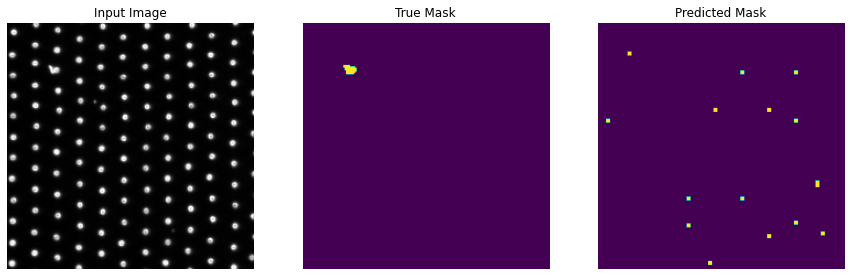

2022-04-01 17:09:26,245:root:INFO - -----END INFERENCE-----


In [46]:
if __name__ == "__main__":
    train_obj = TrainSKInterface()
    #train_obj.run_workflow(True, 0)
    train_obj.run_inference(0)